# Fréchet inception distance 

> In this module, we develop a metric for measuring similarity between images that we can use to semi-objectively measure the quality of our generated images

Adapted from

- [https://youtu.be/PXiD7ZjOKhA?si=-JY6IiV4tvGWZvr9&t=1379](https://youtu.be/PXiD7ZjOKhA?si=-JY6IiV4tvGWZvr9&t=1379)

In [1]:
#| default_exp fid

In [47]:
# |export
import math
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from IPython.utils import io
from scipy import linalg
from sklearn.decomposition import PCA
from torch import tensor
from torch.optim import lr_scheduler
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm

from slowai.augmentation import (
    GlobalAveragePooling,
    ResNet,
    ResNetWithGlobalPooling,
    ResNetWithGlobalPoolingInitialConv,
)
from slowai.ddpm import DDPM, fashion_unet, get_dls, train
from slowai.learner import (
    DeviceCB,
    MetricsCB,
    ProgressCB,
    TrainLearner,
    batchify,
    def_device,
    fashion_mnist,
    show_images,
    to_cpu,
)
from slowai.sgd import BatchSchedulerCB
from slowai.utils import clean_mem, get_grid, glomf, show_image, show_images

In [3]:
# |export
BS = 512

In [4]:
plt.style.use("ggplot")

We want to compute how closely our generated images match the training distribution.

In [5]:
model_fp = Path("../models/fashion_unet.pt")
unet = torch.load(model_fp)
ddpm = DDPM()

In [6]:
ddpm.sample?

Signature: ddpm.sample(model, sz=(16, 1, 32, 32), device='cuda', return_all=False)
Docstring: <no docstring>
File:      ~/Desktop/SlowAI/nbs/slowai/ddpm.py
Type:      method

In [7]:
_28x28 = T.Resize((28, 28), antialias=True)

In [8]:
*earlier, out = ddpm.sample(unet, sz=(BS, 1, 32, 32), return_all=True)
out = _28x28(out)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:57<00:00, 17.30time step/s]


In [9]:
out.shape

torch.Size([512, 1, 28, 28])

In [10]:
clf: ResNetWithGlobalPoolingInitialConv = torch.load(
    "../models/fashion_mnist_classifier.pt"
)

In [11]:
fashion_categories = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

In [12]:
preds = clf(out).argmax(axis=1)
preds = [fashion_categories[pred.cpu().item()] for pred in preds]

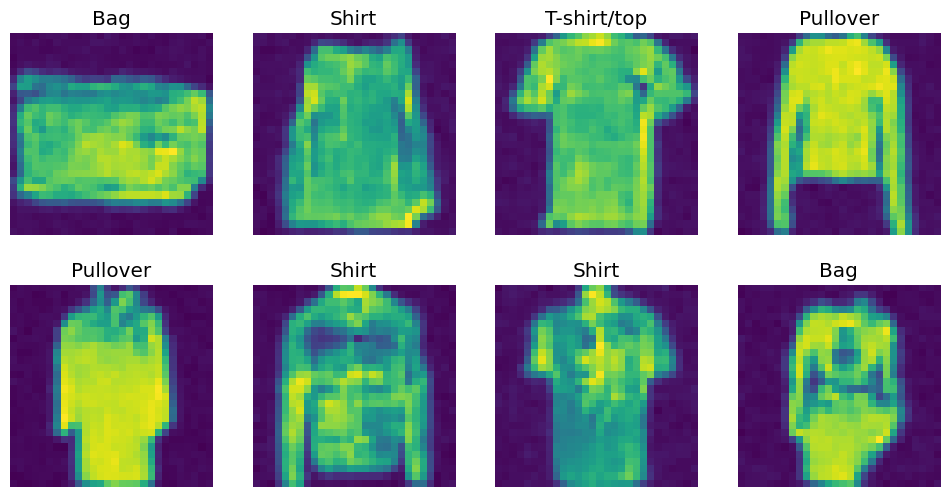

In [13]:
show_images(out[:8, ...], titles=preds[:8])

To do so, we'll use a metric called "Fréchet inception distance" that considers the statistics of the activations. This shall be the global average pool layer of a convolutional classifier. **This does not give us the similarity between individual samples; rather, it considers the summary statistics of a batch of samples.**

Jeremy really strains to use the `Learner` to capture the activations, but its much easier to just implement a hook.

In [14]:
# |export
@contextmanager
def Hook(h):
    yield
    h.remove()


@torch.no_grad()
def get_global_average_pooling(model, xb):
    feat = None

    def h(module: GlobalAveragePooling, _, output):
        nonlocal feat
        feat = output

    with Hook(model.pool.register_forward_hook(h)):
        model(xb)

    assert feat is not None
    return feat

In [15]:
fake_feats = get_global_average_pooling(clf, out)
fake_feats.shape

torch.Size([512, 512])

We can visualize the feature density in a few dimensions.

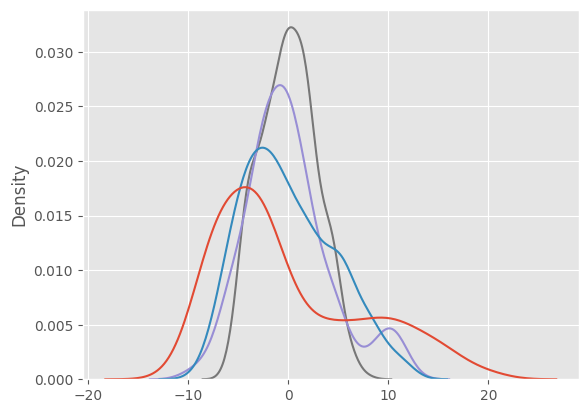

In [16]:
X = PCA(n_components=4).fit_transform(fake_feats.cpu())
sns.kdeplot(X, legend=False);

However, what we really want to capture is the co-variance of one feature with another to be able to "summarize" a batch.

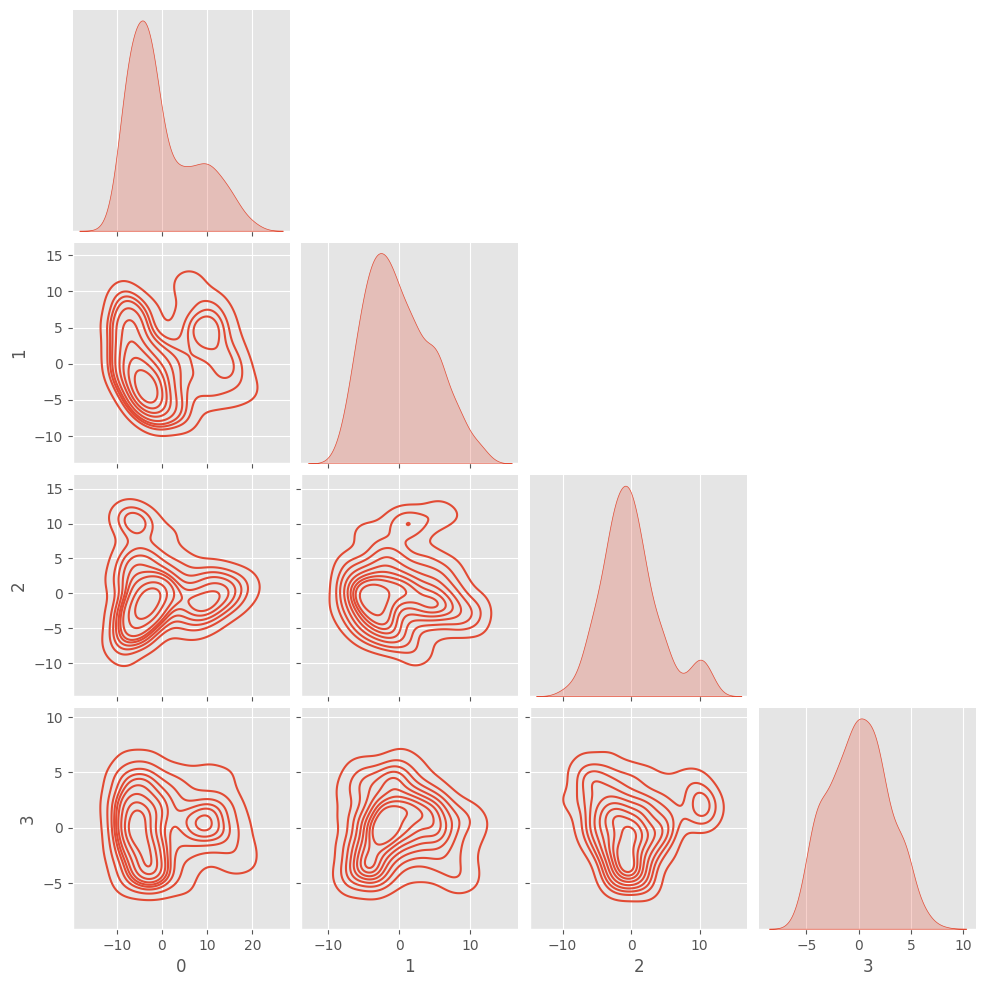

In [17]:
sns.pairplot(pd.DataFrame(X), kind="kde", corner=True)

This figure starts to show how the model makes it simple to draw hyperplanes to make classification decisions. We can also use this where the "real" images have a certain covariance and the "fake" images have a different covariance.

In [18]:
dls = get_dls(BS)

In [19]:
xb, _ = dls.peek()
xb = xb.to(def_device)
real_feats = get_global_average_pooling(clf, xb)
real_feats.shape

torch.Size([512, 512])

In [20]:
# |export
def summarize(X):
    return X.mean(axis=0), X.cov()

In [21]:
(m0, c0), (m1, c1) = summarize(fake_feats), summarize(real_feats)
m0.shape, m1.shape, c0.shape, c1.shape

(torch.Size([512]),
 torch.Size([512]),
 torch.Size([512, 512]),
 torch.Size([512, 512]))

In [22]:
# |export
def fid(real, fake, bs=BS):
    (m0, c0), (m1, c1) = map(to_cpu, (real, fake))
    csr = linalg.sqrtm(c0 @ c1, bs).real  # Matrix square root
    csr = tensor(csr)
    fid_ = ((m0 - m1) ** 2).sum() + c0.trace() + c1.trace() - 2 * csr.trace()
    return fid_.item()

In [23]:
fid(summarize(real_feats), summarize(fake_feats))

210.1156005859375

Note that we take the product of two matrices, so we take the matrix square root to keep the variance within a reasonable boundary. This is the Newton-Schultz method where you compute:
$$
\begin{align*}
a &= \sqrt{x} \\
a^2 &= x \\
a^2 - x &= 0
\end{align*}
$$
By taking the derivative, subtracting a certain amount from the original matrix and determining if the difference between the new matrix squared and the original matrix squared is less than a tolerance.

In [24]:
linalg.sqrtm?

Signature: linalg.sqrtm(A, disp=True, blocksize=64)
Docstring:
Matrix square root.

Parameters
----------
A : (N, N) array_like
    Matrix whose square root to evaluate
disp : bool, optional
    Print warning if error in the result is estimated large
    instead of returning estimated error. (Default: True)
blocksize : integer, optional
    If the blocksize is not degenerate with respect to the
    size of the input array, then use a blocked algorithm. (Default: 64)

Returns
-------
sqrtm : (N, N) ndarray
    Value of the sqrt function at `A`. The dtype is float or complex.
    The precision (data size) is determined based on the precision of
    input `A`. When the dtype is float, the precision is the same as `A`.
    When the dtype is complex, the precision is double that of `A`. The
    precision might be clipped by each dtype precision range.

errest : float
    (if disp == False)

    Frobenius norm of the estimated error, ||err||_F / ||A||_F

References
----------
.. [1] Edvin De

This is called the "Inception" distance because of the use of the [Inception model](https://cloud.google.com/tpu/docs/inception-v3-advanced). This allows us to compare metrics with other papers, but using a special-use classifier can be beneficial.

FID can be biased: 

- FID depends on the batch size, where smaller batches have systematically larger distances
- The Inception model uses an image size of `299x299`, which can cause artifacts if resizing images

To compare with other results from literature, make sure to keep the batch size consistent and make sure your images make a similar size.

The KID (Kernel Inception distance) is designed to mitigate these biases.

:::{.callout-tip}
## What is the KID
Jeremy glosses over the mathematics here, so the following is just copied from the notebook. KID is not common used due to the high variance: it is quite dependant on the random seed. This underscores that **there is no unbiased metric of image distribution similarity.** Human evaluation is the gold standard.
:::

In [25]:
# |export
def _squared_mmd(x, y):
    def k(a, b):
        return (a @ b.transpose(-2, -1) / a.shape[-1] + 1) ** 3

    m, n = x.shape[-2], y.shape[-2]
    kxx, kyy, kxy = k(x, x), k(y, y), k(x, y)
    kxx_sum = kxx.sum([-1, -2]) - kxx.diagonal(0, -1, -2).sum(-1)
    kyy_sum = kyy.sum([-1, -2]) - kyy.diagonal(0, -1, -2).sum(-1)
    kxy_sum = kxy.sum([-1, -2])
    return kxx_sum / m / (m - 1) + kyy_sum / n / (n - 1) - kxy_sum * 2 / m / n

In [26]:
# |export
def kid(x, y, maxs=50):
    xs, ys = x.shape[0], y.shape[0]
    n = max(math.ceil(min(xs / maxs, ys / maxs)), 4)
    mmd = 0.0
    for i in range(n):
        cur_x = x[round(i * xs / n) : round((i + 1) * xs / n)]
        cur_y = y[round(i * ys / n) : round((i + 1) * ys / n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd / n).item()

In [27]:
kid(real_feats, fake_feats)

0.5280609130859375

Let's make this a class.

In [28]:
# |export
class ImageEval:
    def __init__(self, inception, x_example):
        self.inception = inception.to(def_device)
        self.feats = self.featurize(x_example.to(def_device))
        self.summary = summarize(self.feats)

    def featurize(self, x):
        return get_global_average_pooling(self.inception, x.to(def_device))

    def fid(self, x):
        x = self.featurize(x)
        return fid(summarize(x), self.summary)

    def kid(self, x):
        return kid(self.featurize(x), self.feats)

    @classmethod
    def fashion_mnist(cls, fp="../models/fashion_mnist_classifier.pt", bs=512):
        from slowai.augmentation import (
            GlobalAveragePooling,
            ResNetWithGlobalPoolingInitialConv,
        )

        dls = get_dls(bs)
        xb, _ = dls.peek()
        clf = torch.load(fp)
        return cls(clf, xb)

In [29]:
img_eval = ImageEval(clf, xb)
img_eval.kid(out), img_eval.fid(out)

(0.5280614495277405, 209.6070556640625)

For comparison, we need to look at another real batch of data to see the ideal FID.

In [30]:
dl = iter(dls["train"])
_ = next(dl)
xb2, _ = next(dl)
img_eval.fid(xb2.cuda())

177.6341552734375

Now, we can show that denoising improves the FID over the sampling trajectory.

In [32]:
fids = []
for i, x in enumerate(tqdm([*earlier, out][::10])):
    fids.append((i, img_eval.fid(x)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.82it/s]


(0.0, 1246.0123291015625)

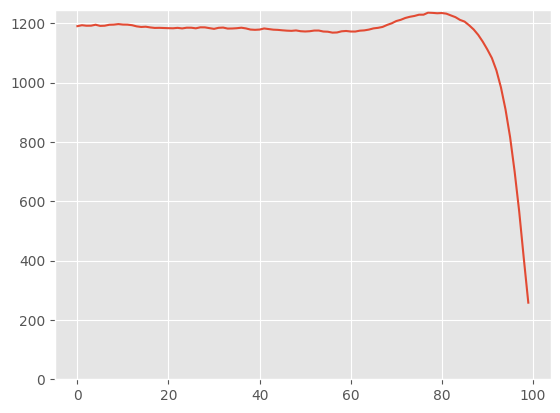

In [33]:
fig, ax = plt.subplots(1, 1)
x, y = zip(*fids)
ax.plot(x, y)
ax.set_ylim(0, max(y) + 10)

:::{.callout-tip}
## What should the minimum and maximum values be for images?
Jeremy mentions here that he noticed a "bug" where our dataset is normalized between 0 and 1, whereas everyone else normalizes between -1 and 1. However, when he implemented this "fix", performance was much worse. It was only when he normalized between -0.5 and 1 that the model performance improved compared to 0 and 1 normalization.
:::

Let's try Jeremy's experiments here.

Note that the original validation accuracy was 91.7%.

In [34]:
del unet
clean_mem()

In [35]:
def train_clf(model, dls, lr=1e-2, n_epochs=2):
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    acc = MetricsCB(MulticlassAccuracy(num_classes=10))
    cbs = [
        acc,
        DeviceCB(),
        ProgressCB(plot=False),
        scheduler,
    ]
    learner = TrainLearner(
        model,
        dls,
        F.cross_entropy,
        lr=lr,
        cbs=cbs,
        opt_func=partial(torch.optim.AdamW, eps=1e-5),
    )
    learner.fit(n_epochs)
    return acc.metrics["MulticlassAccuracy"].compute()

In [36]:
pipe = [T.PILToTensor(), T.ConvertImageDtype(torch.float), T.Pad((2, 2))]
to_tensor = T.Compose(pipe)

In [42]:
def get_norm_dls(a, b):
    def norm(x):
        return (to_tensor(x) - a) / b

    return (
        fashion_mnist(512)
        .with_transforms({"image": batchify(norm)}, lazy=True)
        .listify()
    )

In [43]:
xb, _ = get_norm_dls(0, 1).peek()
xb.shape

torch.Size([512, 1, 32, 32])

In [44]:
def classification_accuracy_for_normalization(a, b, n_epochs=2):
    dls = get_norm_dls(a, b)
    batch, _ = dls.peek()
    nfs = [
        16,
        32,
        64,
        128,
        256,
    ]
    model = ResNetWithGlobalPooling.kaiming(nfs)
    dls = get_norm_dls(a, b)
    xb, _ = dls.peek()
    range_ = (batch.min().item(), batch.max().item())
    return range_, train_clf(model, dls=dls, n_epochs=n_epochs)

In [48]:
res = []
for a, b in tqdm([(0, 1), (0.5, 0.5), (0.5, 1)]):
    with io.capture_output():
        (min_, max_), acc = classification_accuracy_for_normalization(a, b)
    res.append((min_, max_, acc))
res

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:40<00:00, 13.47s/it]


[(0.0, 1.0, tensor(0.9150)),
 (-1.0, 1.0, tensor(0.9153)),
 (-0.5, 0.5, tensor(0.9132))]

These are all within 0.1% of one another and, moreover, the range that he said was dramatically better was slight _worse_ than the one he said was the worst (-1 to 1). I'm not sure if Jeremy is right here.

In [3]:
#| hide
import nbdev

nbdev.nbdev_export()